# 音楽ジャンル分類（music2vec）

    [参考サイト]
    https://qiita.com/KMASAHIRO/items/cae4dfb0657eec4a2dca

# データの用意

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pip install wget

  Using cached wget-3.2.zip (10 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=73d34b2432a8be20e1ad464b7503ec24da4d9077e3186abd4e9086eb4647aefd
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [5]:
import wget
import shutil
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import librosa
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

<ipython-input-5-f9c4ef9ac1cf>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  ms.use('seaborn-muted')


### データの前処理

In [6]:
# ドライブ上のフォルダを指定
drive_folder_path = '/content/drive/MyDrive/卒業論文/GTZAN'

# Colabにフォルダをコピー
colab_folder_path = '/content/genres'
shutil.copytree(drive_folder_path, colab_folder_path)

# コピーされたフォルダ内のファイル/フォルダを確認
os.listdir(colab_folder_path)

['metal',
 'hiphop',
 'classical',
 'rock',
 'blues',
 'reggae',
 'country',
 'pop',
 'jazz',
 'disco']

In [7]:
# SoundNetの事前学習済み重みをgithub上から持ってくる
# クローンの作成
! git clone https://github.com/KMASAHIRO/music2vec

Cloning into 'music2vec'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 67 (delta 3), reused 4 (delta 1), pack-reused 56
Receiving objects: 100% (67/67), 154.06 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (12/12), done.


In [8]:
# ロードする音楽ファイル名の作成
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

gtzan_filenames = list()

for genre in genre_list:
  for i in range(100):
    gtzan_filenames.append("/content/genres/" + genre + "/" + genre + ".000{:02}.wav".format(i))

gtzan_filenames = np.asarray(gtzan_filenames)

In [9]:
# ラベルの作成（ex.）[1.0.0.0.0.0.0.0.0.0]
gtzan_labels = list()

for i in range(10):
  for k in range(100):
    gtzan_labels.append(tf.one_hot(i,10))

gtzan_labels = np.asarray(gtzan_labels)

In [10]:
# データをシャッフル(最初はジャンルごとにソートされている)
np_random = np.random.RandomState(seed=1)
new_gtzan_filenames = np_random.permutation(gtzan_filenames)
np_random = np.random.RandomState(seed=1)
new_gtzan_labels = np_random.permutation(gtzan_labels)

In [11]:
# DANetのテストデータと同じテストデータを使用する
# 後でDANetの出力を分類させるタスクを行うため
with open("/content/music2vec/test_data.txt","rb") as f:
  data_dict = pickle.load(f)

lacia_test_filenames = data_dict['gtzan_filenames']
test_labels = data_dict['gtzan_labels']

In [12]:
# DANet訓練時とデータの配置場所が異なるので、ファイルのパスを変更する
test_filenames = list()
for file in lacia_test_filenames:
  splitted = file.split('/')[2:]
  test_filenames.append('/content/'+'/'.join(splitted))
test_filenames = np.asarray(test_filenames)

In [13]:
# 先に用意していた音楽ファイルの内、テストデータとなるものを抽出
duplicated_index = list()
for file in test_filenames:
  index = np.argmax(new_gtzan_filenames==file)
  duplicated_index.append(index)

In [14]:
# テストデータを用意していた音楽ファイルから取り除き、訓練データとして使用する
train_filenames = np.delete(new_gtzan_filenames,duplicated_index,axis=0)
train_labels = np.delete(new_gtzan_labels,duplicated_index,axis=0)

In [15]:
# 音楽ファイルをロードして訓練データを生成するジェネレータ
def generator(filenames, labels, batch_size):
  index = 0
  seed_num = 0
  new_filenames = filenames.copy()
  new_labels = labels.copy()
  while True:
    train_inputs = list()
    train_labels = list()
    if index+batch_size>len(filenames):
      index = 0
      np_random = np.random.RandomState(seed=seed_num)
      new_filenames = np_random.permutation(new_filenames)
      np_random = np.random.RandomState(seed=seed_num)
      new_labels = np_random.permutation(new_labels)
      seed_num += 1

    for i in range(batch_size):
      y,sr = librosa.load(new_filenames[index],sr=22050,mono=True,dtype=np.float32)
      y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
      y *= 256.0
      y = np.reshape(y,(-1,1))
      train_inputs.append(y)
      train_labels.append(new_labels[index])
      index += 1
    train_inputs = np.asarray(train_inputs)
    train_labels = np.asarray(train_labels)

    yield train_inputs, train_labels

In [16]:
# 訓練データをsoundnetに入力して出力を平坦化したものをpca分析するときに使うジェネレータ
def pca_generator(filenames, labels, batch_size):
  index = 0
  seed_num = 0
  new_filenames = filenames.copy()
  new_labels = labels.copy()
  while True:
    train_inputs = list()
    train_labels = list()
    if index+batch_size>len(filenames):
      batch_size = len(filenames) - index

    for i in range(batch_size):
      y,sr = librosa.load(new_filenames[index],sr=22050,mono=True,dtype=np.float32)
      y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
      y *= 256.0
      y = np.reshape(y,(-1,1))
      train_inputs.append(y)
      train_labels.append(new_labels[index])
      index += 1
    train_inputs = np.asarray(train_inputs)
    train_labels = np.asarray(train_labels)

    yield train_inputs, train_labels

In [17]:
# テストデータは量が少なくメモリが十分なので先にロードしておく
test_inputs = list()
for file in test_filenames:
  y,sr = librosa.load(file,sr=22050,mono=True,dtype=np.float32)
  y = np.concatenate((y,np.zeros(675808-len(y))),axis=0)
  y *= 256.0
  y = np.reshape(y,(-1,1))
  test_inputs.append(y)
test_inputs = np.asarray(test_inputs)

### モデルの構築と学習


- 事前学習済みの重みを用いてSoundNetを構築する関数(https://github.com/pseeth/soundnet_keras/blob/master/soundnet.py より)

In [18]:
# 以下修正あり
from keras.layers import BatchNormalization, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
import numpy as np
import librosa

In [19]:
from tensorflow.keras.layers import BatchNormalization, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer
from tensorflow.keras.models import Sequential
import numpy as np
import librosa

def build_model():
    """
    Builds up the SoundNet model and loads the weights from a given model file (8-layer model is kept at models/sound8.npy).
    :return:
    """
    model_weights = np.load('/content/music2vec/music2vec/sound8.npy',allow_pickle=True,encoding='bytes').item()

    keys = list()
    for key in model_weights.keys():
      keys.append(key)
    for name in keys:
      model_weights[name.decode('utf-8')] = model_weights[name]
      model_weights.pop(name)
      ch_keys = list()
      for key in model_weights[name.decode('utf-8')]:
        ch_keys.append(key)
      for ch_name in ch_keys:
        model_weights[name.decode('utf-8')][ch_name.decode('utf-8')] = model_weights[name.decode('utf-8')][ch_name]
        model_weights[name.decode('utf-8')].pop(ch_name)

    model = Sequential()
    model.add(InputLayer(batch_input_shape=(None, None, 1)))

    filter_parameters = [{'name': 'conv1', 'num_filters': 16, 'padding': 32,
                          'kernel_size': 64, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv2', 'num_filters': 32, 'padding': 16,
                          'kernel_size': 32, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv3', 'num_filters': 64, 'padding': 8,
                          'kernel_size': 16, 'conv_strides': 2},

                         {'name': 'conv4', 'num_filters': 128, 'padding': 4,
                          'kernel_size': 8, 'conv_strides': 2},

                         {'name': 'conv5', 'num_filters': 256, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2,
                          'pool_size': 4, 'pool_strides': 4},

                         {'name': 'conv6', 'num_filters': 512, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv7', 'num_filters': 1024, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv8_2', 'num_filters': 401, 'padding': 0,
                          'kernel_size': 8, 'conv_strides': 2},
                         ]

    for x in filter_parameters:
        model.add(ZeroPadding1D(padding=x['padding']))
        model.add(Conv1D(x['num_filters'],
                         kernel_size=x['kernel_size'],
                         strides=x['conv_strides'],
                         padding='valid'))
        weights = model_weights[x['name']]['weights'].reshape(model.layers[-1].get_weights()[0].shape)
        biases = model_weights[x['name']]['biases']

        model.layers[-1].set_weights([weights, biases])

        if 'conv8' not in x['name']:
            gamma = model_weights[x['name']]['gamma']
            beta = model_weights[x['name']]['beta']
            mean = model_weights[x['name']]['mean']
            var = model_weights[x['name']]['var']


            model.add(BatchNormalization())
            model.layers[-1].set_weights([gamma, beta, mean, var])
            model.add(Activation('relu'))
        if 'pool_size' in x:
            model.add(MaxPooling1D(pool_size=x['pool_size'],
                                   strides=x['pool_strides'],
                                   padding='valid'))

    return model

- モデル構築

In [20]:
soundnet = build_model()

In [21]:
soundnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding1d (ZeroPaddin  (None, None, 1)           0         
 g1D)                                                            
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1040      
                                                                 
 batch_normalization (Batch  (None, None, 16)          64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, None, 16)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 16)          0         
 D)                                                              
                                                        

In [22]:
music2vec_input = tf.keras.Input(shape=(675808,1))
x = soundnet(music2vec_input)
x = tf.keras.layers.LSTM(200,return_sequences=True)(x)
x = tf.keras.layers.LSTM(200,return_sequences=True)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(400)(x)
x = tf.keras.layers.Dense(100)(x)
music2vec_output = tf.keras.layers.Dense(10,activation='softmax')(x)
music2vec = tf.keras.Model(inputs=music2vec_input,outputs=music2vec_output)

# 学習

In [23]:
music2vec.compile(optimizer='rmsprop',loss='CategoricalCrossentropy',metrics=['accuracy'])

In [24]:
batch_size = 25
steps = len(train_filenames)//batch_size

In [25]:
music2vec.fit(x=generator(train_filenames,train_labels,batch_size),steps_per_epoch=steps,
              validation_data=(test_inputs,test_labels),epochs=10,initial_epoch=0)

Epoch 1/10
38/38 [==============================] - 40s 513ms/step - loss: 2.7706 - accuracy: 0.1768 - val_loss: 2.1241 - val_accuracy: 0.2000
Epoch 2/10
38/38 [==============================] - 13s 351ms/step - loss: 1.8448 - accuracy: 0.3411 - val_loss: 1.5862 - val_accuracy: 0.4000
Epoch 3/10
38/38 [==============================] - 12s 329ms/step - loss: 1.5648 - accuracy: 0.4337 - val_loss: 1.9416 - val_accuracy: 0.3400
Epoch 4/10
38/38 [==============================] - 11s 301ms/step - loss: 1.4125 - accuracy: 0.4832 - val_loss: 1.6327 - val_accuracy: 0.4000
Epoch 5/10
38/38 [==============================] - 13s 344ms/step - loss: 1.2557 - accuracy: 0.5653 - val_loss: 1.4191 - val_accuracy: 0.5000
Epoch 6/10
38/38 [==============================] - 12s 325ms/step - loss: 1.1750 - accuracy: 0.5832 - val_loss: 1.3073 - val_accuracy: 0.5800
Epoch 7/10
38/38 [==============================] - 11s 298ms/step - loss: 1.0737 - accuracy: 0.6411 - val_loss: 1.1835 - val_accuracy: 0.6200

In [26]:
music2vec.save("music2vec_10epochs.h5",save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
music2vec = tf.keras.models.load_model('/content/music2vec_10epochs.h5')

In [28]:
music2vec.fit(x=generator(train_filenames,train_labels,batch_size),steps_per_epoch=steps,
              validation_data=(test_inputs,test_labels),epochs=20,initial_epoch=10)

Epoch 11/20
38/38 [==============================] - 21s 416ms/step - loss: 0.6593 - accuracy: 0.7863 - val_loss: 1.1671 - val_accuracy: 0.6600
Epoch 12/20
38/38 [==============================] - 13s 334ms/step - loss: 0.5682 - accuracy: 0.8063 - val_loss: 1.0203 - val_accuracy: 0.6400
Epoch 13/20
38/38 [==============================] - 14s 366ms/step - loss: 0.5066 - accuracy: 0.8326 - val_loss: 1.4204 - val_accuracy: 0.7000
Epoch 14/20
38/38 [==============================] - 12s 310ms/step - loss: 0.4998 - accuracy: 0.8358 - val_loss: 1.3138 - val_accuracy: 0.7000
Epoch 15/20
38/38 [==============================] - 12s 328ms/step - loss: 0.3830 - accuracy: 0.8758 - val_loss: 1.5344 - val_accuracy: 0.6600
Epoch 16/20
38/38 [==============================] - 13s 342ms/step - loss: 0.4032 - accuracy: 0.8726 - val_loss: 0.8820 - val_accuracy: 0.7400
Epoch 17/20
38/38 [==============================] - 13s 336ms/step - loss: 0.3717 - accuracy: 0.8632 - val_loss: 1.4804 - val_accuracy:

In [29]:
music2vec.save("music2vec_20epochs.h5",save_format="h5")

In [31]:
history = music2vec.fit(x=generator(train_filenames,train_labels,batch_size),steps_per_epoch=steps,validation_data=(test_inputs,test_labels),epochs=20,initial_epoch=10)

Epoch 11/20
38/38 [==============================] - 23s 614ms/step - loss: 0.2000 - accuracy: 0.9263 - val_loss: 1.9737 - val_accuracy: 0.7000
Epoch 12/20
38/38 [==============================] - 12s 313ms/step - loss: 0.1381 - accuracy: 0.9547 - val_loss: 2.0491 - val_accuracy: 0.6000
Epoch 13/20
38/38 [==============================] - 13s 343ms/step - loss: 0.1902 - accuracy: 0.9379 - val_loss: 1.4372 - val_accuracy: 0.7200
Epoch 14/20
38/38 [==============================] - 13s 350ms/step - loss: 0.1230 - accuracy: 0.9568 - val_loss: 2.4589 - val_accuracy: 0.6200
Epoch 15/20
38/38 [==============================] - 12s 314ms/step - loss: 0.0962 - accuracy: 0.9653 - val_loss: 2.6193 - val_accuracy: 0.6600
Epoch 16/20
38/38 [==============================] - 13s 331ms/step - loss: 0.1396 - accuracy: 0.9600 - val_loss: 1.8223 - val_accuracy: 0.7000
Epoch 17/20
38/38 [==============================] - 14s 365ms/step - loss: 0.1253 - accuracy: 0.9653 - val_loss: 1.5767 - val_accuracy:

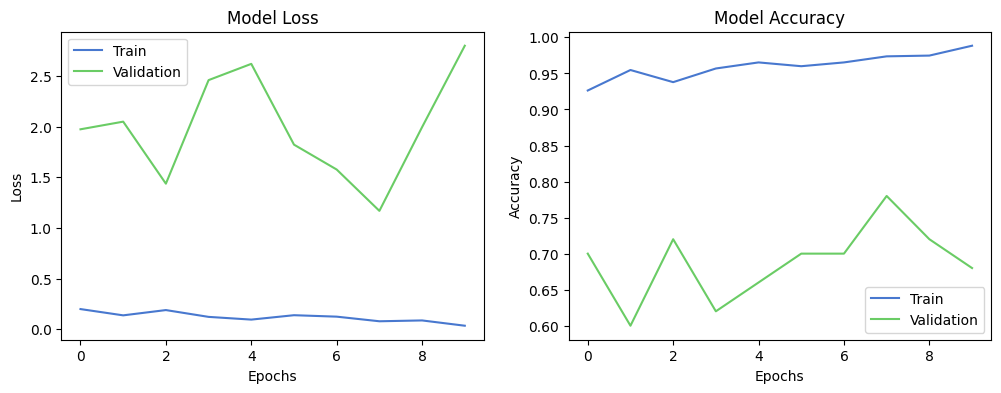

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 学習様子の可視化
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # 損失のプロット
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 精度のプロット
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 学習様子を可視化
plot_history(history)


# 結果

## 混同行列

### 10epochs後

In [33]:
# モデルのロード
music2vec = tf.keras.models.load_model('/content/music2vec_10epochs.h5')

In [34]:
# 推論
result = music2vec.predict(test_inputs,batch_size=25)

2/2 [==============================] - 1s 31ms/step


In [35]:
# Accuracyを求める
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(test_labels, result)
print(m.result().numpy())

0.64


In [36]:
# モデルの出力やラベルと、それが表すジャンルを対応させる
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

genre_pred = list()
genre_true = list()
for i in range(len(test_labels)):
  genre_pred.append(genre_list[tf.math.argmax(result[i],axis=0)])
  genre_true.append(genre_list[tf.math.argmax(test_labels[i],axis=0)])

In [37]:
# 混同行列の作成
df = pd.DataFrame(confusion_matrix(genre_true, genre_pred, labels=genre_list))
df.columns = genre_list
df.index = genre_list

In [38]:
df

blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
blues          1          0        2      0       0     1      0    0       0   
classical      0          4        0      0       0     0      0    0       0   
country        0          0        8      0       0     0      0    0       0   
disco          0          0        2      4       0     0      1    0       0   
hiphop         0          0        0      0       3     0      0    0       0   
jazz           0          0        2      0       0     5      0    0       0   
metal          0          0        0      0       0     0      1    0       0   
pop            1          0        0      0       0     0      0    3       0   
reggae         1          0        1      0       0     0      0    0       2   
rock           0          0        6      0       0     0      0    0       0   

           rock  
blues         0  
classical     0  
country       0  
disco         0  
hiphop        0  
jazz          0  
metal         1  
pop           0  
reggae        0  
rock          1

### 20epochs後

In [39]:
# モデルのロード
music2vec = tf.keras.models.load_model('/content/music2vec_20epochs.h5')

In [40]:
# 推論
result = music2vec.predict(test_inputs,batch_size=25)

2/2 [==============================] - 1s 27ms/step


In [41]:
# Accuracyを求める
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(test_labels, result)
print(m.result().numpy())

0.76


In [42]:
# モデルの出力やラベルと、それが表すジャンルを対応させる
genre_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

genre_pred = list()
genre_true = list()
for i in range(len(test_labels)):
  genre_pred.append(genre_list[tf.math.argmax(result[i],axis=0)])
  genre_true.append(genre_list[tf.math.argmax(test_labels[i],axis=0)])

In [43]:
# 混同行列の作成
df = pd.DataFrame(confusion_matrix(genre_true, genre_pred, labels=genre_list))
df.columns = genre_list
df.index = genre_list

In [44]:
df

blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
blues          3          0        1      0       0     0      0    0       0   
classical      0          4        0      0       0     0      0    0       0   
country        2          0        5      0       0     0      0    0       0   
disco          0          0        0      6       0     0      1    0       0   
hiphop         0          0        0      0       3     0      0    0       0   
jazz           2          0        1      0       0     4      0    0       0   
metal          0          0        0      0       0     0      2    0       0   
pop            1          0        0      0       0     0      0    3       0   
reggae         0          0        0      0       0     0      0    0       4   
rock           1          0        1      0       0     0      0    1       0   

           rock  
blues         0  
classical     0  
country       1  
disco         0  
hiphop        0  
jazz          0  
metal         0  
pop           0  
reggae        0  
rock          4

### まとめ

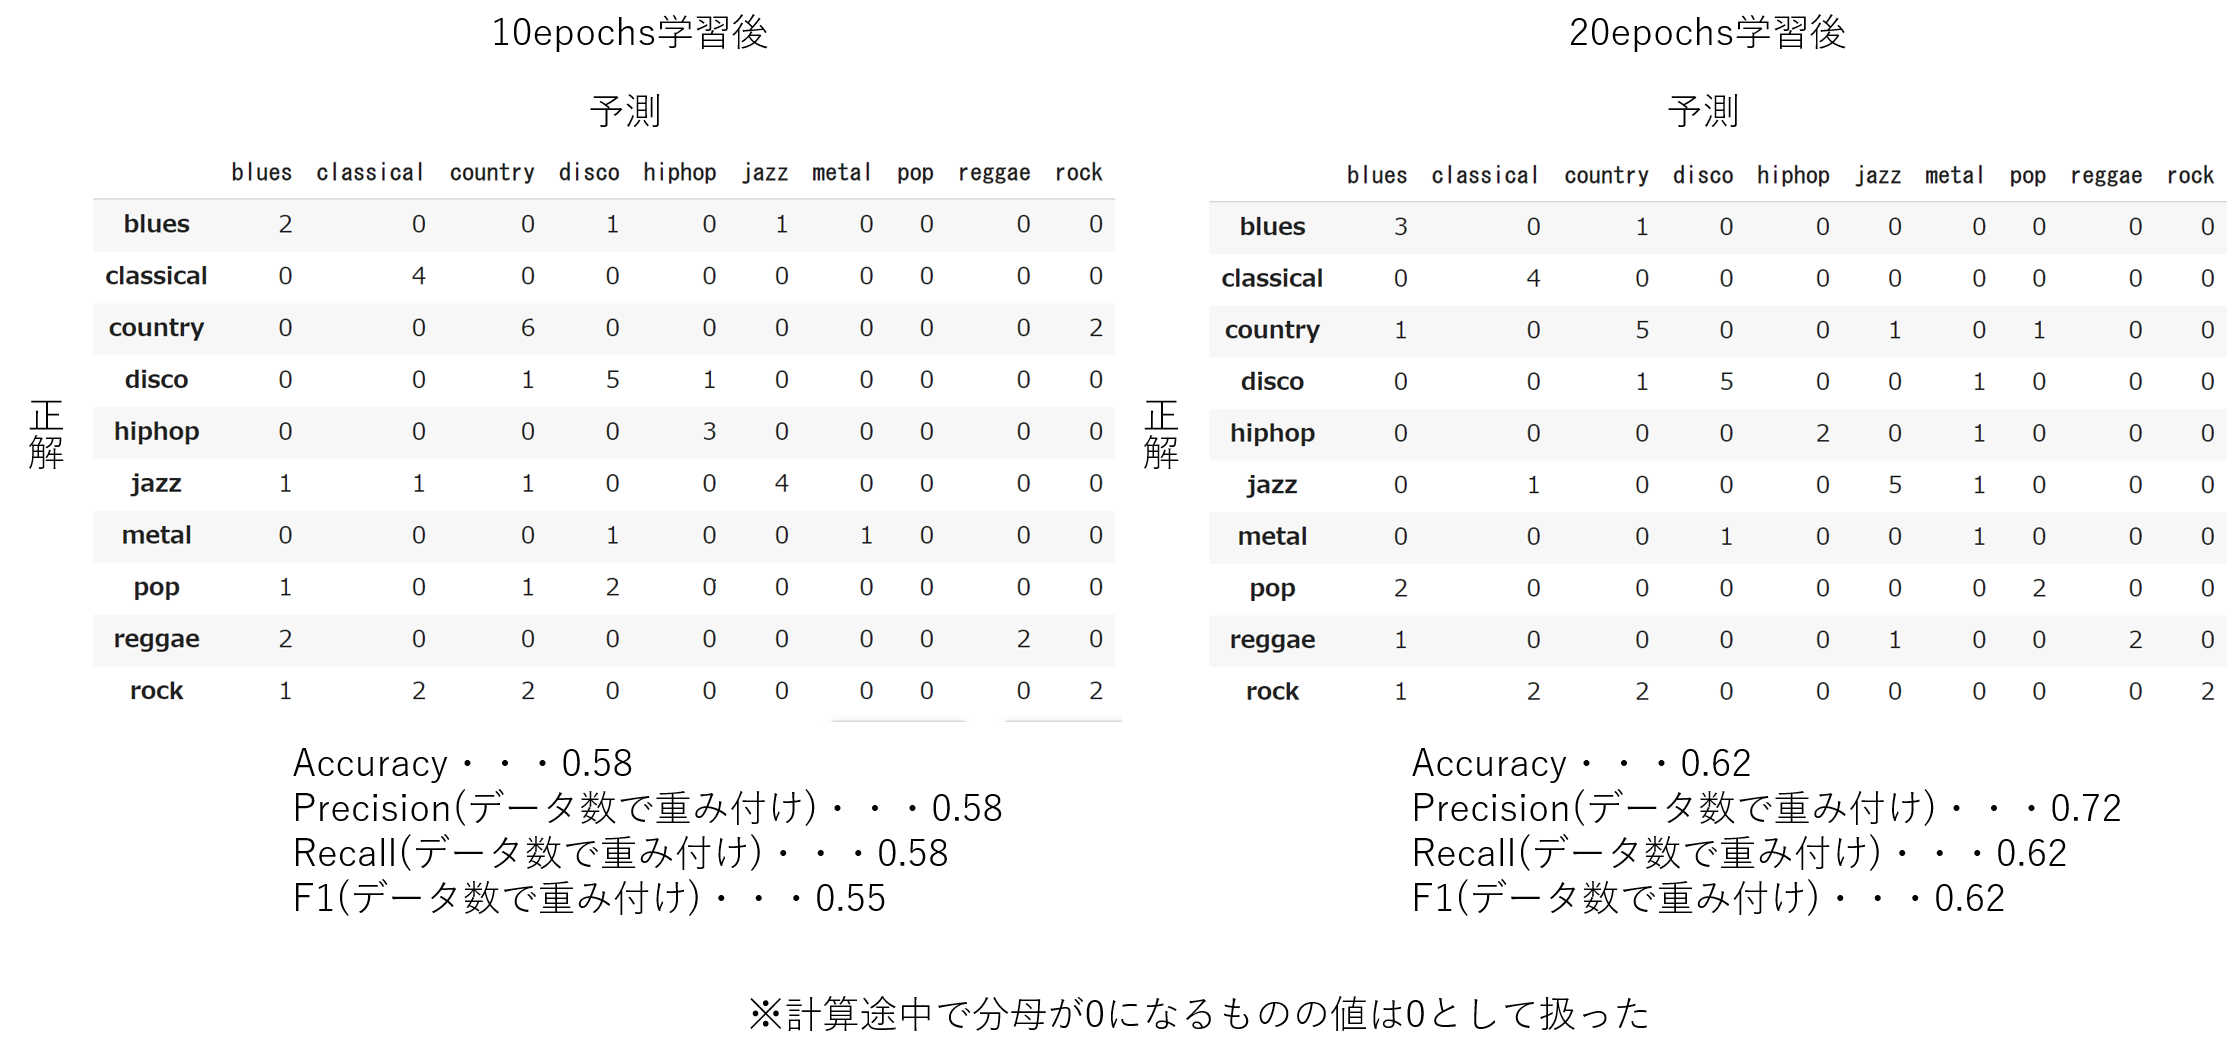

In [45]:
Image.open("/content/music2vec/confusion_matrix.png")

## SoundNet出力を平坦化したものをPCA、t-SNEで可視化

### 学習前

In [46]:
soundnet = build_model()

#### テストデータ

In [47]:
output = soundnet.predict(test_inputs)

2/2 [==============================] - 0s 144ms/step


##### PCA

In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=2)

In [50]:
pca.fit(output.reshape(50,-1))

PCA(n_components=2)

In [51]:
feature = pca.transform(output.reshape(50,-1))

In [52]:
num_label = tf.math.argmax(test_labels,axis=1)

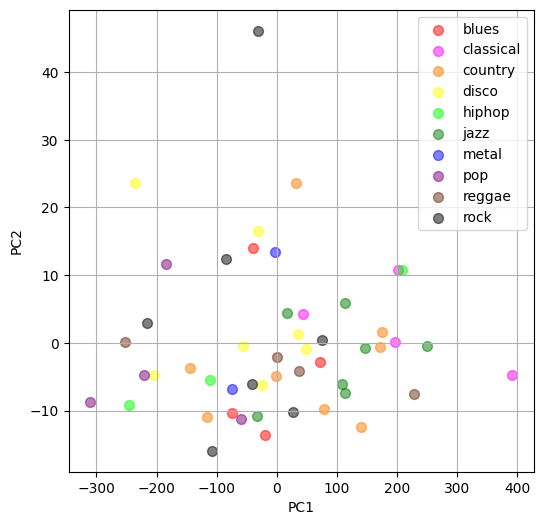

In [53]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [54]:
from sklearn.manifold import TSNE

In [55]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(50,-1))

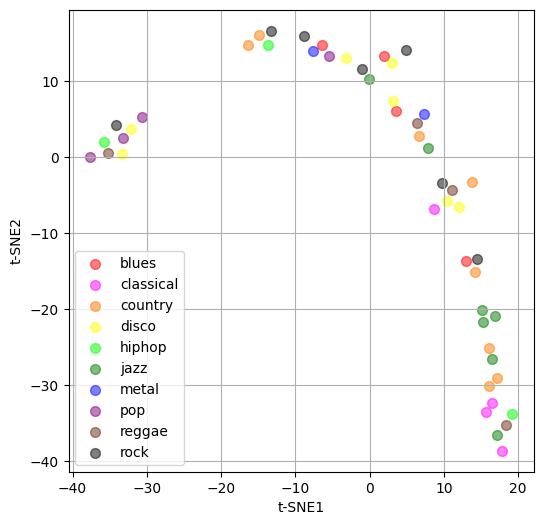

In [56]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [57]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(50,-1))

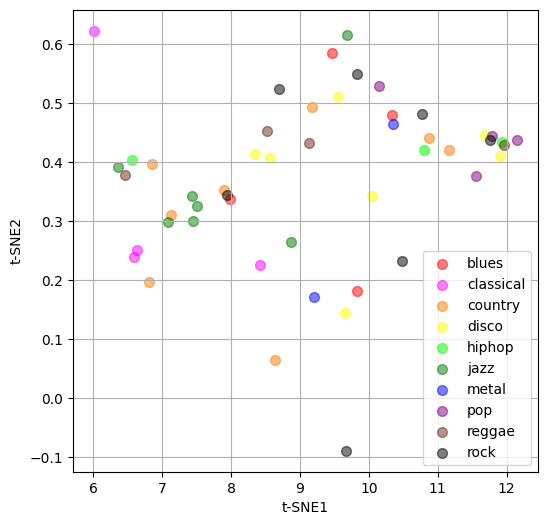

In [58]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

#### 訓練データ

In [59]:
output = soundnet.predict(x=pca_generator(train_filenames,train_labels,25),steps=38)

38/38 [==============================] - 11s 295ms/step


##### PCA

In [60]:
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components=2)

In [62]:
pca.fit(output.reshape(950,-1))

PCA(n_components=2)

In [63]:
feature = pca.transform(output.reshape(950,-1))

In [64]:
num_label = tf.math.argmax(train_labels,axis=1)

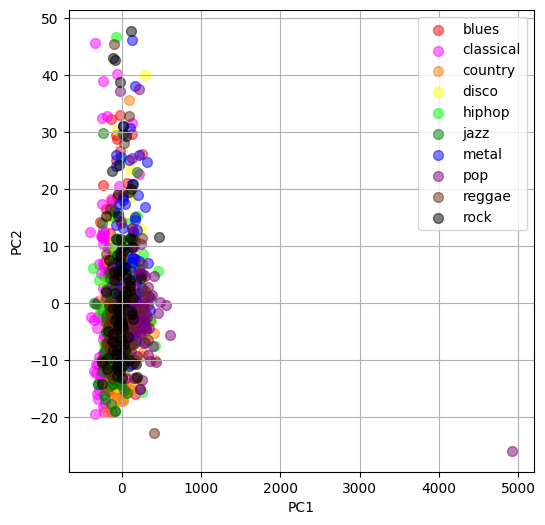

In [65]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

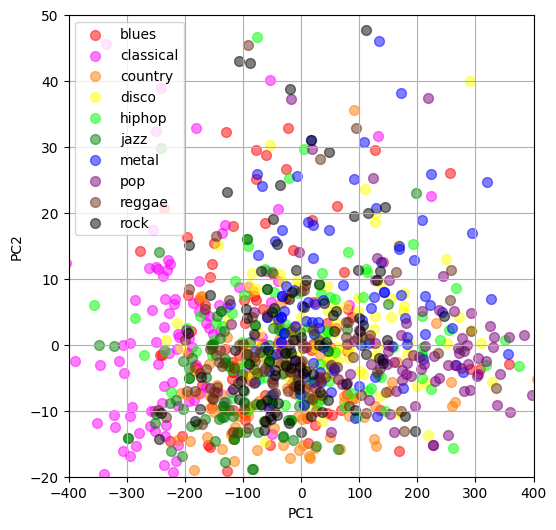

In [66]:
# 拡大したPCA
plt.figure(figsize=(6, 6))

plt.xlim((-400,400))
plt.ylim((-20,50))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [67]:
from sklearn.manifold import TSNE

In [68]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(950,-1))

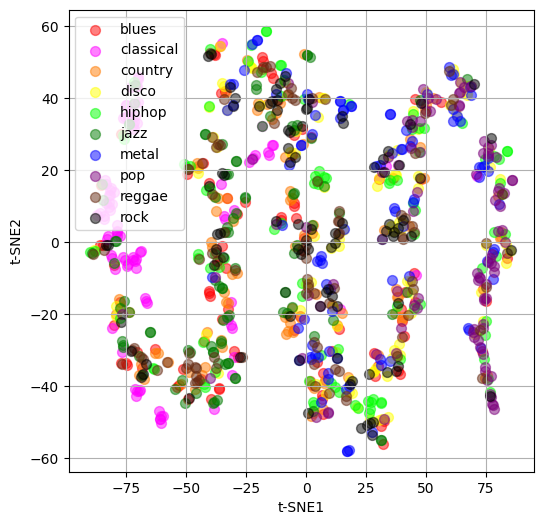

In [69]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [70]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(950,-1))

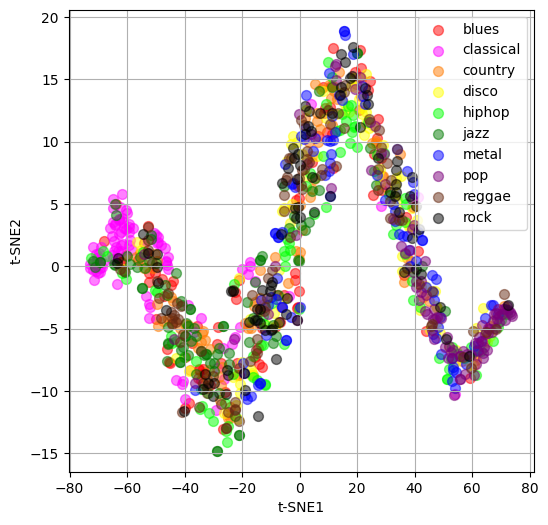

In [71]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

### 10epochs学習後

In [72]:
music2vec = tf.keras.models.load_model('/content/music2vec_10epochs.h5')

#### テストデータ

In [73]:
soundnet = tf.keras.Model(inputs=music2vec.get_layer(index=1).input, outputs=music2vec.get_layer(index=1).output)

In [74]:
output = soundnet.predict(test_inputs)

2/2 [==============================] - 0s 143ms/step


##### PCA

In [75]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components=2)

In [77]:
pca.fit(output.reshape(50,-1))

PCA(n_components=2)

In [78]:
feature = pca.transform(output.reshape(50,-1))

In [79]:
num_label = tf.math.argmax(test_labels,axis=1)

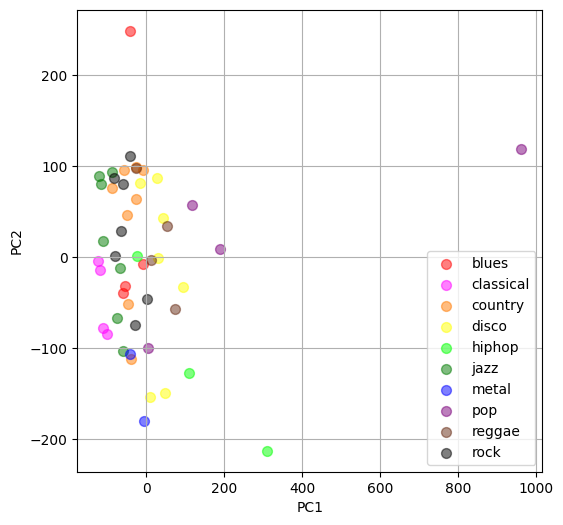

In [80]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [81]:
from sklearn.manifold import TSNE

In [82]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(50,-1))

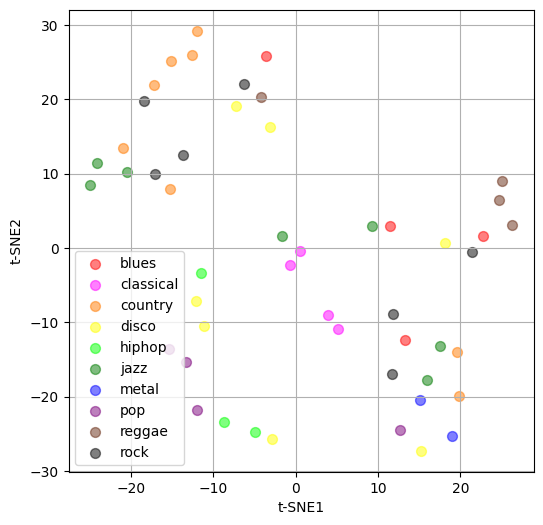

In [83]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [84]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(50,-1))

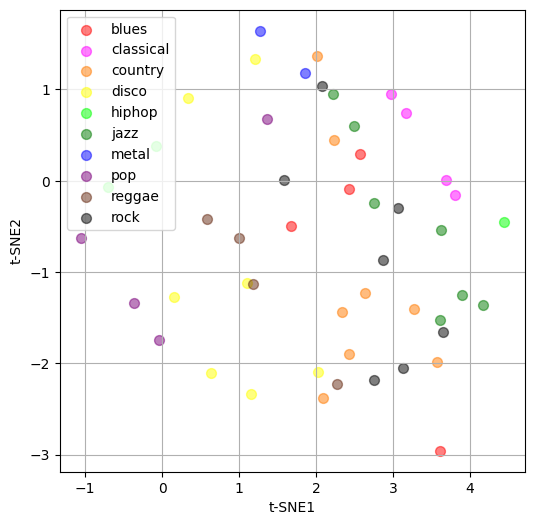

In [85]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

#### 訓練データ

In [86]:
output = soundnet.predict(x=pca_generator(train_filenames,train_labels,25),steps=38)

38/38 [==============================] - 12s 298ms/step


##### PCA

In [87]:
from sklearn.decomposition import PCA

In [88]:
pca = PCA(n_components=2)

In [89]:
pca.fit(output.reshape(950,-1))

PCA(n_components=2)

In [90]:
feature = pca.transform(output.reshape(950,-1))

In [91]:
num_label = tf.math.argmax(train_labels,axis=1)

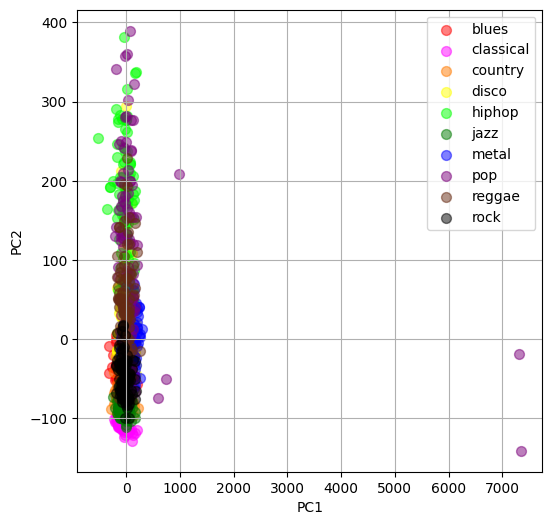

In [92]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

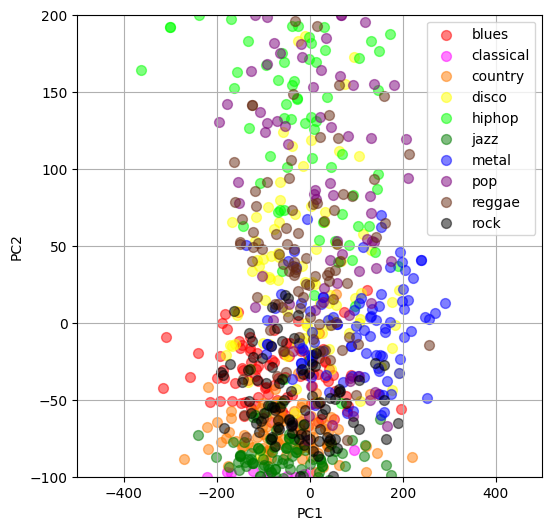

In [93]:
# 拡大したPCA
plt.figure(figsize=(6, 6))

plt.xlim((-500,500))
plt.ylim((-100,200))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [94]:
from sklearn.manifold import TSNE

In [95]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(950,-1))

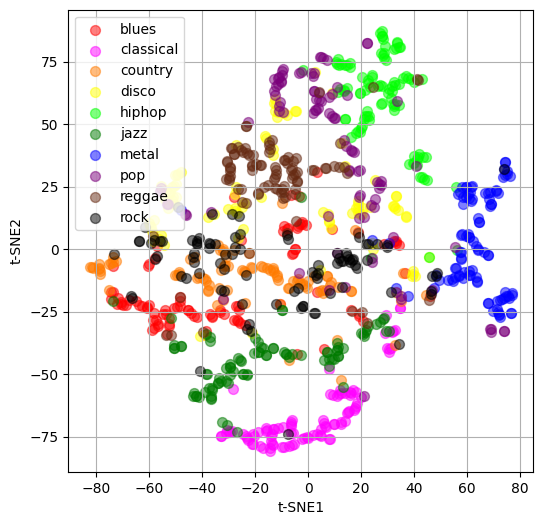

In [96]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [97]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(950,-1))

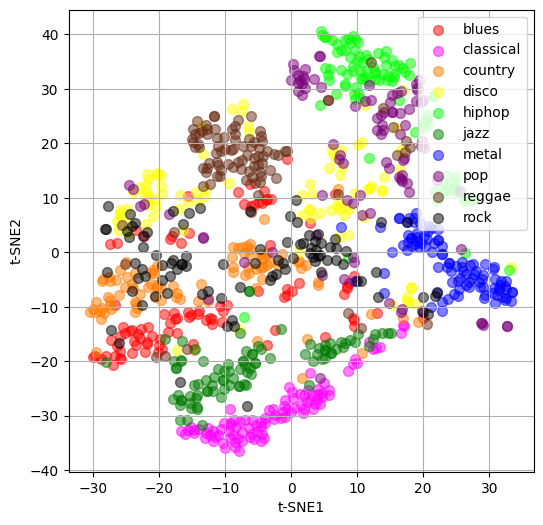

In [98]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

### 20epochs学習後

In [99]:
music2vec = tf.keras.models.load_model('/content/music2vec_20epochs.h5')

#### テストデータ

In [100]:
soundnet = tf.keras.Model(inputs=music2vec.get_layer(index=1).input, outputs=music2vec.get_layer(index=1).output)

In [101]:
output = soundnet.predict(test_inputs)

2/2 [==============================] - 0s 146ms/step


##### PCA

In [102]:
from sklearn.decomposition import PCA

In [103]:
pca = PCA(n_components=2)

In [104]:
pca.fit(output.reshape(50,-1))

PCA(n_components=2)

In [105]:
feature = pca.transform(output.reshape(50,-1))

In [106]:
num_label = tf.math.argmax(test_labels,axis=1)

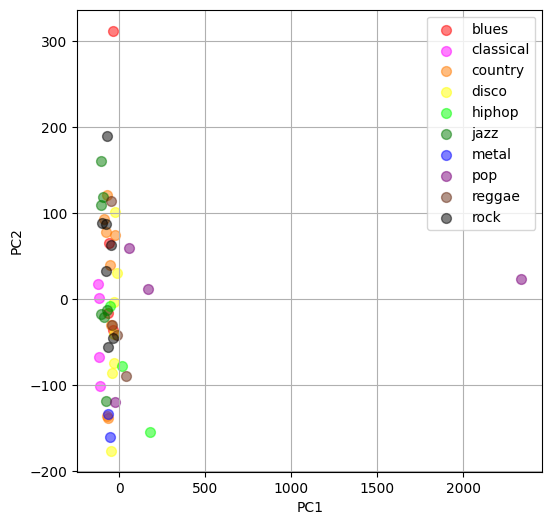

In [107]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [108]:
from sklearn.manifold import TSNE

In [109]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(50,-1))

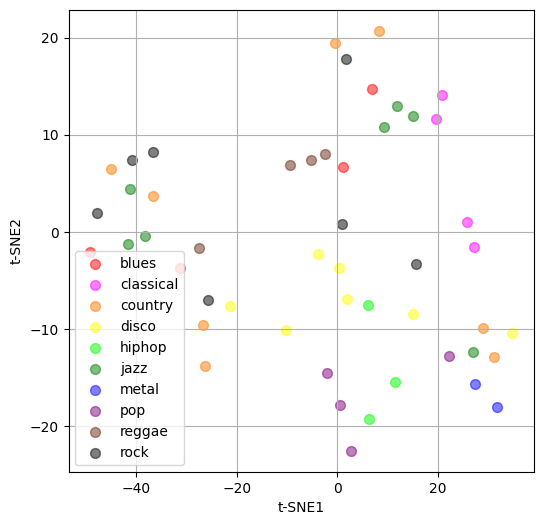

In [110]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [111]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(50,-1))

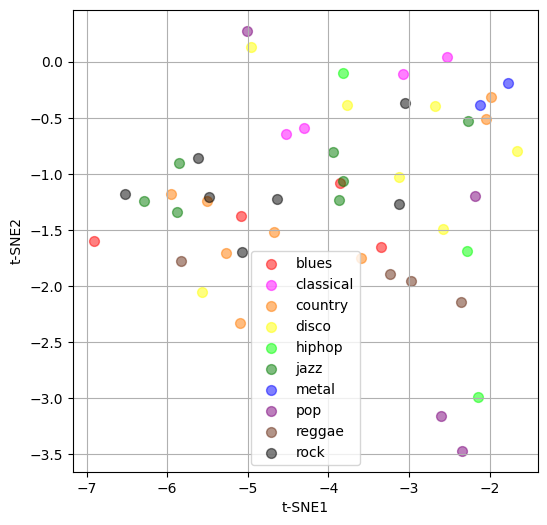

In [112]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

#### 訓練データ

In [113]:
output = soundnet.predict(x=pca_generator(train_filenames,train_labels,25),steps=38)

38/38 [==============================] - 10s 262ms/step


##### PCA

In [114]:
from sklearn.decomposition import PCA

In [115]:
pca = PCA(n_components=2)

In [116]:
pca.fit(output.reshape(950,-1))

PCA(n_components=2)

In [117]:
feature = pca.transform(output.reshape(950,-1))

In [118]:
num_label = tf.math.argmax(train_labels,axis=1)

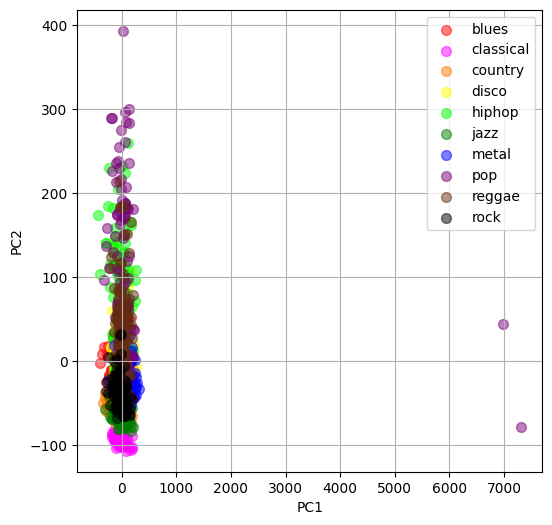

In [119]:
# PCA
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

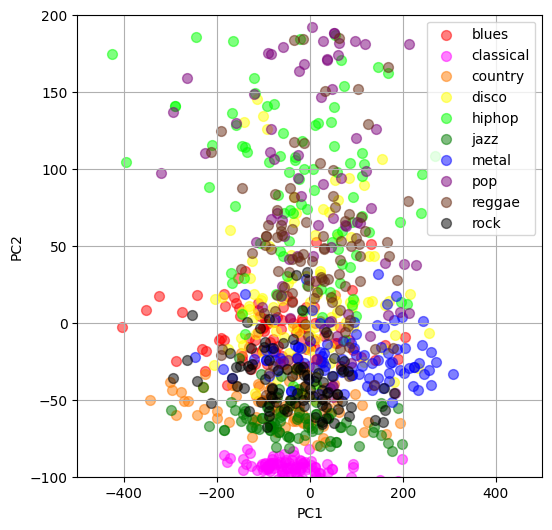

In [120]:
# 拡大したPCA
plt.figure(figsize=(6, 6))

plt.xlim((-500,500))
plt.ylim((-100,200))
plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best')

plt.show()

##### t-SNE

In [121]:
from sklearn.manifold import TSNE

In [122]:
tsne = TSNE(perplexity=5)
feature = tsne.fit_transform(output.reshape(950,-1))

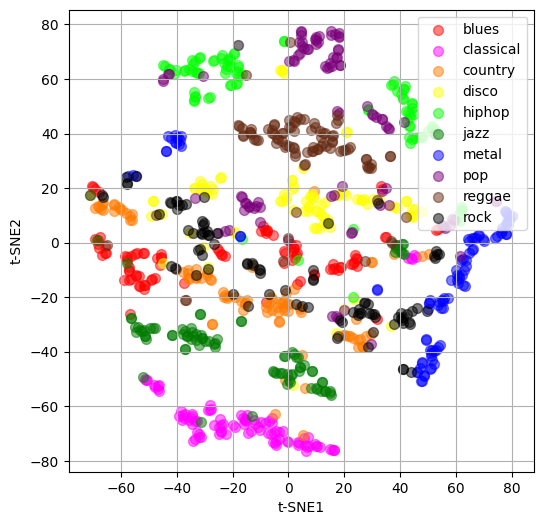

In [123]:
# perplexity=5
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

In [124]:
tsne = TSNE()
feature = tsne.fit_transform(output.reshape(950,-1))

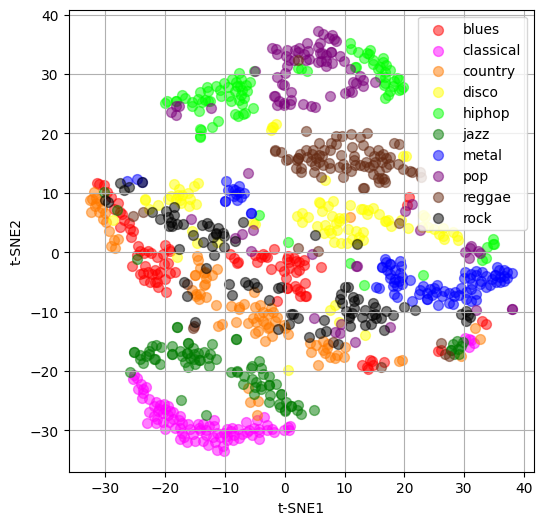

In [125]:
# デフォルトのperplexity(perplexity=30)
plt.figure(figsize=(6, 6))

plt.scatter(feature[num_label==0, 0], feature[num_label==0, 1], alpha=0.5,c="#ff0000",label='blues',s=50)
plt.scatter(feature[num_label==1, 0], feature[num_label==1, 1], alpha=0.5,c="#ff00ff",label='classical',s=50)
plt.scatter(feature[num_label==2, 0], feature[num_label==2, 1], alpha=0.5,c="#ff7b00",label='country',s=50)
plt.scatter(feature[num_label==3, 0], feature[num_label==3, 1], alpha=0.5,c="#ffff00",label='disco',s=50)
plt.scatter(feature[num_label==4, 0], feature[num_label==4, 1], alpha=0.5,c="#00ff00",label='hiphop',s=50)
plt.scatter(feature[num_label==5, 0], feature[num_label==5, 1], alpha=0.5,c="#007b00",label='jazz',s=50)
plt.scatter(feature[num_label==6, 0], feature[num_label==6, 1], alpha=0.5,c="#0000ff",label='metal',s=50)
plt.scatter(feature[num_label==7, 0], feature[num_label==7, 1], alpha=0.5,c="#7b007b",label='pop',s=50)
plt.scatter(feature[num_label==8, 0], feature[num_label==8, 1], alpha=0.5,c="#662a12",label='reggae',s=50)
plt.scatter(feature[num_label==9, 0], feature[num_label==9, 1], alpha=0.5,c="#000000",label='rock',s=50)
plt.grid(True)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(loc='best')

plt.show()

### まとめ

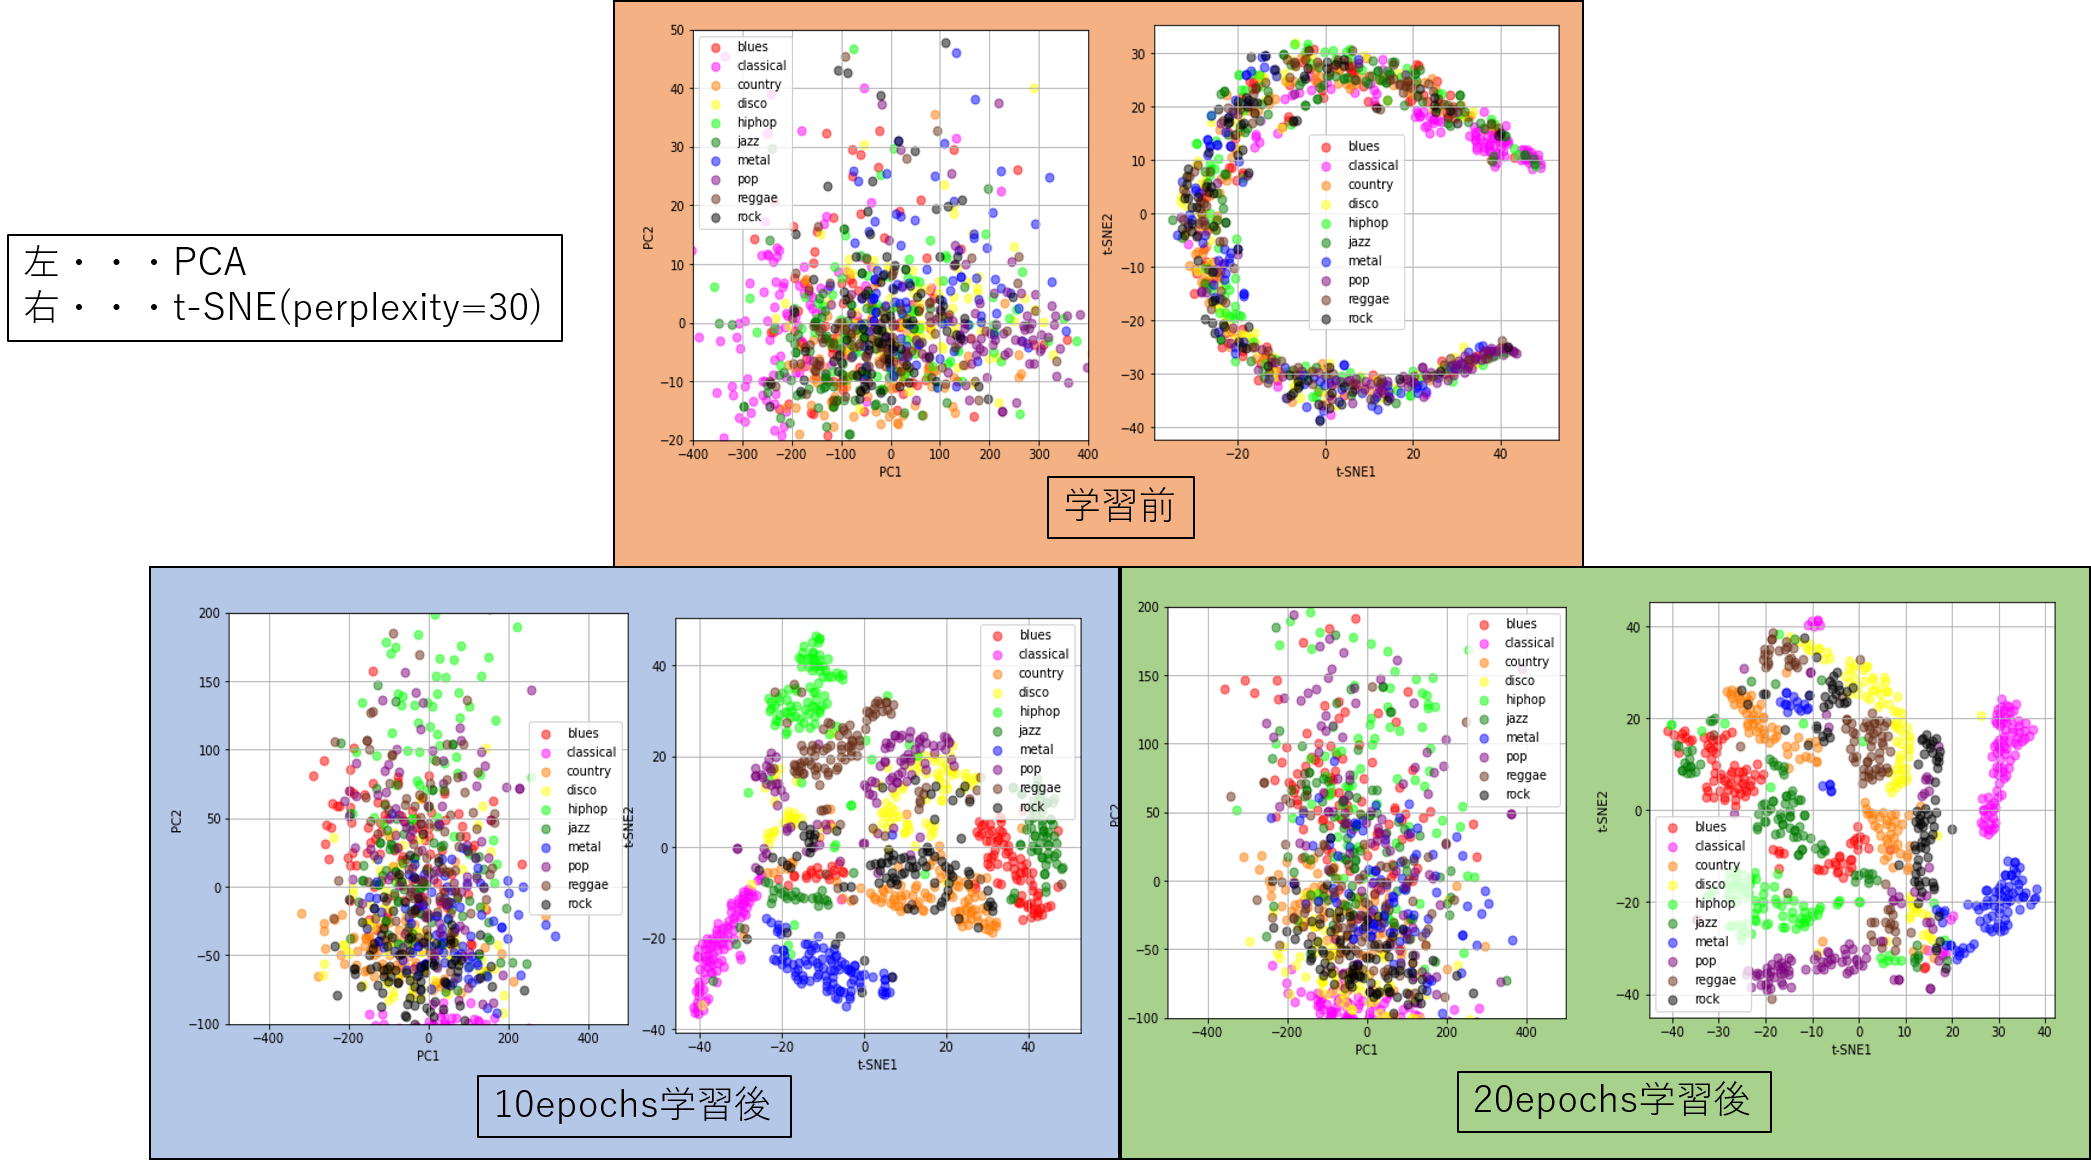

In [126]:
Image.open("/content/music2vec/analysis.png")